In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torchvision.models import vgg19
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder


In [2]:
import datasets #same dir

In [4]:
parentDir = "C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/"
metaDataDir = "C:/Users/josem/Documents/schoolWork/MQP/Git/MQPCode/test/subjCocoImgData/"

In [3]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

parentDir = "./algonauts_2023_challenge_data/"
metaDataDir = "./subjCocoImgData/"

tsfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
trainingDataset = datasets.COCOImgWithLabel(parentDir, metaDataDir,1, tsfms)
trainDataLoader = DataLoader(trainingDataset, batch_size = 32, shuffle = True)

In [7]:
class cocoVGG (torch.nn.Module):
    def __init__(self, numClasses):
        super(cocoVGG, self).__init__()
        self.vgg = vgg19(weights="DEFAULT")
        self.features = self.vgg.features
        self.avgpool = torch.nn.AdaptiveAvgPool2d((7,7))
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features = 25088, out_features = 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features = 4096, out_features = 1024),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features = 1024, out_features = numClasses)
        )
    def forward(self, img):
        x = self.features(img)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [8]:
numClasses = 79

model = cocoVGG(numClasses).to(device)

In [57]:
model.classifier[0].parameters()

<generator object Module.parameters at 0x000001EA47E97CA0>

In [9]:
device = "cpu"

numClasses = 79
model = vgg19(weights = "DEFAULT")
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features = 25088, out_features = 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features = 4096, out_features = 1024),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features = 1024, out_features = numClasses),
)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
for data in trainDataLoader:
    img, label = data
    break

In [9]:
label

tensor([22, 14, 27, 48, 10, 40, 56, 22, 10, 36, 48, 17, 10, 34, 18, 75, 48, 51,
        56, 48, 25, 28, 36, 22, 74, 48, 18, 64, 20, 62, 72, 78],
       dtype=torch.int32)

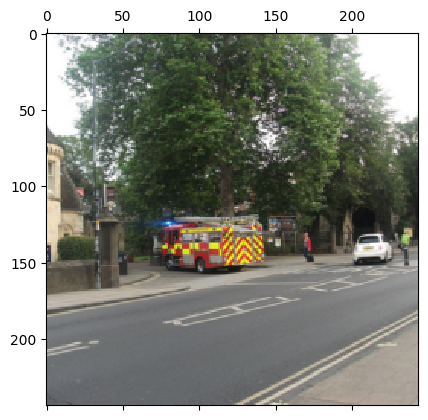

In [50]:
plt.matshow(img.permute(1,2,0))

In [ ]:
for i in model.parameters():
    i.grad

In [6]:
device = "cpu"

In [10]:
model = cocoVGG(numClasses).to(device)

optim = torch.optim.Adam(model.parameters(), 0.00001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
model.train()
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    avgLoss = 0
    numRight = 0
    for data in tqdm(trainDataLoader, desc="Training", unit="batch"):  # for data in trainDataLoader: #
        img, label = data
        img = img.to(device)
        label = label.to(device)
        optim.zero_grad()
        pred = model(img)
        loss = criterion(pred, label)
        if torch.isnan(loss):
            print("nan")
        loss.backward()
        optim.step()
        # print(pred.shape)
        # print(pred)
        numRight += (torch.argmax(pred, 1) == label).sum().item()
        avgLoss += loss.item()
    # print("layer1")
    # print(list(model.classifier[0].parameters()))
    # print("grads")
    # for paramss in model.classifier[0].parameters():
    #     print(paramss.grad)
    # print("layer2")
    # print(list(model.classifier[2].parameters()))
    # print("layer3")
    # print(list(model.classifier[4].parameters()))
    print(f"Epoch {epoch}  CE: {avgLoss / len(trainDataLoader)}, Acc: {numRight / len(trainingDataset)}, got {numRight} right")

        

Epoch 0


Training:   0%|          | 1/308 [00:09<46:09,  9.02s/batch]

Pred 48, target 22
Pred 48, target 14
Pred 48, target 27
Pred 48, target 48
Pred 48, target 10
Pred 48, target 40
Pred 48, target 56
Pred 48, target 22
Pred 48, target 10
Pred 48, target 36
Pred 48, target 48
Pred 48, target 17
Pred 48, target 10
Pred 48, target 34
Pred 48, target 18
Pred 48, target 75
Pred 48, target 48
Pred 48, target 51
Pred 48, target 56
Pred 48, target 48
Pred 48, target 25
Pred 48, target 28
Pred 48, target 36
Pred 48, target 22
Pred 48, target 74
Pred 48, target 48
Pred 48, target 18
Pred 48, target 64
Pred 48, target 20
Pred 48, target 62
Pred 48, target 72
Pred 48, target 78


Training:   0%|          | 1/308 [00:18<1:32:19, 18.04s/batch]


KeyboardInterrupt: 